# Прогнозирование заказов такси

### Задача

---

Для сервиса такси нужно построить модель, которая будет предсказывать количество заказов такси в аэропортах на следующий час. Таким образом можно будет привлекать больше водителей в период пиковой нагрузки.

*Условие*: значение метрики RMSE на тесте должно быть не больше 48.

### Данные

---

В нашем распоряжении есть исторические данные о заказах такси.

Описание данных:
- `datetime` - момент времени
- `num_orders` - количество заказов

### План проекта:

---

1. Предобработка данных.
    - Загрузка данных, ресемплирование данных. Создание признаков.
2. Анализ данных.
    - Поиск тренда и сезонностей.
3. Обучение моделей.
    - Линейная регрессия, RandomForest, LightGBM, CatBoost. 
4. Вывод.

---

## Предобработка данных

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [2]:
RANDOM_STATE = 42

### Чтение данных

При чтении данных в датафрейм укажем в качестве индекса колонку `datetime` и сразу же приведем ее к типу *datetime64*.

In [3]:
data = pd.read_csv("../datasets/taxi.csv", index_col=[0], parse_dates=[0])

Проверим, расположены ли записи в хронологическом порядке. Если нет, то отсортируем их. Также проверим на наличие дубликатов.

In [4]:
if not data.index.is_monotonic_increasing:
    data.sort_index(inplace=True)

display(data.head())
print(data.info())
print("Дубликатов нет") if data.index.is_unique else print("Есть дубликаты")

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None
Дубликатов нет


### Ресемплирование

Так как нам нужно предсказывать количество заказов такси на каждый час, то ресемплируем данные по интервалу в один час и посчитаем суммарное количество заказов. 

In [5]:
data = data.resample('1H').sum()

### Создание признаков

Напишем функцию для создания признаков. Среди признаков будут: календарные признаки (месяц, день, день недели, час), отстающие (lag) значения, скользящее среднее.

In [6]:
def make_features(data, max_lag, rolling_mean_size):
    
    result = data.copy()
    
    result['month'] = data.index.month
    result['day'] = data.index.day
    result['dayofweek'] = data.index.dayofweek
    result['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        result['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    result['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return result

In [7]:
data_ext = make_features(data, 24, 4)

## Анализ данных

Проанализируем временной ряд.

У нас есть данные за период в полгода: от '2018-03-01 00' до '2018-08-31 23'. Попробуем обнаружить тренд за этот период, а также сезонные изменения в пределах недели и дня.

### Тренд

Чтобы не мешала периодичность более высокого порядка, ресемплируем данные по дням.

In [8]:
decomposed_day = seasonal_decompose(data.resample('1D').sum())

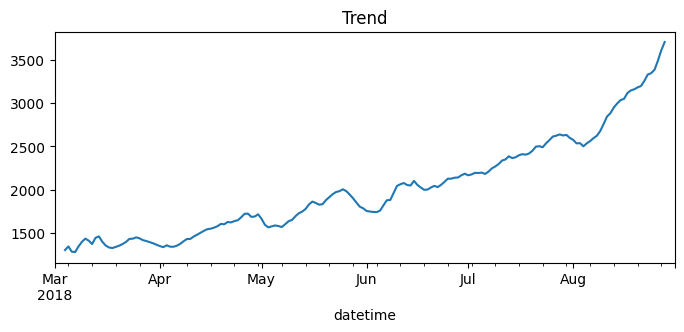

In [9]:
plt.figure(figsize=(8, 3))
decomposed_day.trend.plot(title='Trend')
plt.show()

На графике хорошо прослеживается рост числа заказов такси в аэропорт за полгода.

### Сезонность

Посмотрим, как изменяется число заказов такси в течение **недели**.

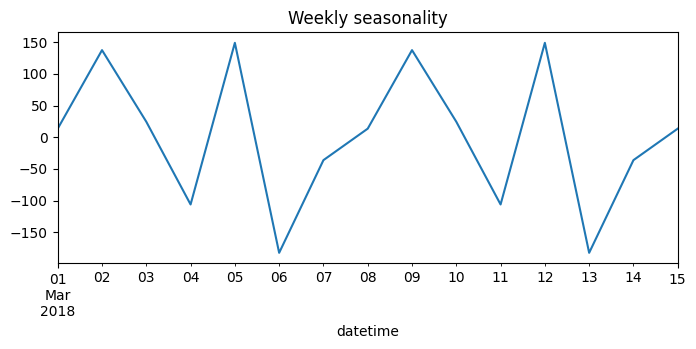

In [10]:
plt.figure(figsize=(8, 3))
decomposed_day.seasonal['2018-03-01':'2018-03-15'].plot(title='Weekly seasonality')
plt.show()

Здесь видны пики в пятницу и понедельник. То есть больше всего заказов такси в аэропорт приходится на начало и конец рабочей недели.

Посмотрим, как изменяется число заказов такси в течение **дня**. Для этого воспользуемся ресемплингом по часам.

In [11]:
decomposed_hour = seasonal_decompose(data)

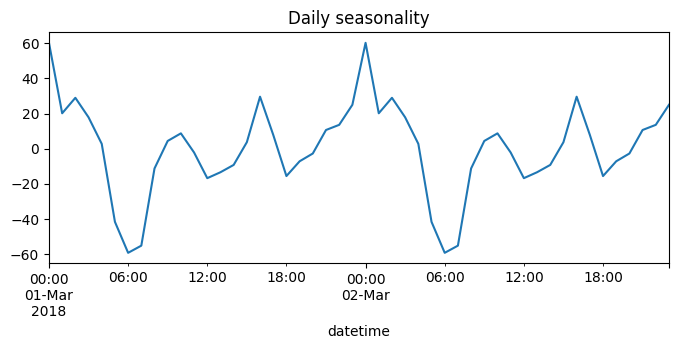

In [12]:
plt.figure(figsize=(8, 3))
decomposed_hour.seasonal['2018-03-01':'2018-03-2'].plot(title='Daily seasonality')
plt.show()

Судя по графику, самое непопулярное время - 6:00. Затем в течение дня наблюдаются несколько пиков: в ~10:00, в ~16:00 и самое загруженное время - в ~00:00.

## Обучение

Разделим данные на обучающую и тестовую выборки в соотношении 9:1.

In [13]:
data_ext.dropna(inplace=True)

X = data_ext.drop('num_orders', axis=1)
y = data_ext['num_orders']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)

In [14]:
print('Размеры выборок:')
print(f'train - {len(X_train)} - {len(X_train)/len(data):.0%}')
print(f'test - {len(X_test)} - {len(X_test)/len(data):.0%}')

Размеры выборок:
train - 3952 - 89%
test - 440 - 10%


Обучим четыре модели: линейную регрессию, случайный лес, LightGBM и CatBoost.  Для последних трех применим поиск гиперпараметров через GridSearchCV. Качество моделей оценим кросс-валидацией с метрикой RMSE и разделением на фолды TimeSeriesSplit.

In [15]:
tscv = TimeSeriesSplit(n_splits=4)

In [16]:
def fit_model(estimator, param_grid, X_train, y_train):
    # подбирает лучшую модель с помощью гридсерча и выводит rmse и параметры лучшей модели;
    # разделение на фолды через TimeSeriesSplit
    model = GridSearchCV(estimator=estimator, 
                            param_grid=param_grid, 
                            n_jobs=-1, 
                            cv=tscv,
                            scoring='neg_root_mean_squared_error')

    model.fit(X_train, y_train)

    best_index = model.best_index_
    best_rmse = round(model.cv_results_['mean_test_score'][best_index], 1)

    print(f"Best RMSE: {abs(best_rmse)}")
    print(f"Best params: {model.best_params_}")

    return model.best_estimator_

**1) Линейная регрессия**

In [17]:
lr_estimator = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

scores = cross_val_score(lr_estimator, X_train, y_train, scoring='neg_root_mean_squared_error', cv=tscv)

rmse = scores.mean()
print(f"RMSE: {abs(rmse):.1f}")

RMSE: 27.2


**2) RandomForestRegressor**

In [18]:
%%time
rf_param_grid = {
    'n_estimators': list(range(50, 121, 10)),
    "max_depth": list(range(7, 16, 2)),
}

rf_best_model = fit_model(
    estimator=RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1),
    param_grid=rf_param_grid,
    X_train=X_train,
    y_train=y_train
)

Best RMSE: 25.9
Best params: {'max_depth': 13, 'n_estimators': 80}
CPU times: total: 16.8 s
Wall time: 1min 26s


**3) LGBMRegressor**

In [19]:
%%time
lgbm_param_grid = {
    "n_estimators": range(100, 201, 15), 
    "max_depth": range(2, 9, 2),
    'learning_rate': [0.01, 0.05, 0.1]
}

lgbm_best_model = fit_model(
    estimator=LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1, verbose=-1),
    param_grid=lgbm_param_grid,
    X_train=X_train,
    y_train=y_train
)

Best RMSE: 25.3
Best params: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 145}
CPU times: total: 4.34 s
Wall time: 37.3 s


**4) CatBoostRegressor**

In [20]:
%%time
catboost_param_grid = {
    "iterations": range(150, 301, 50),
    "learning_rate": [0.05, 0.1, 0.15],
    "depth": range(2, 12, 3)
}

catboost_best_model = fit_model(
    estimator=CatBoostRegressor(random_state=RANDOM_STATE, verbose=False),
    param_grid=catboost_param_grid,
    X_train=X_train,
    y_train=y_train
)

Best RMSE: 25.0
Best params: {'depth': 5, 'iterations': 250, 'learning_rate': 0.1}
CPU times: total: 11.9 s
Wall time: 15min 19s


В качестве лучшей модели выберем CatBoostRegressor, так как метрика rmse у нее лучше остальных.

### Тестирование

Проверим качесто выбранной модели на тестовой выборке.

In [21]:
pred = catboost_best_model.predict(X_test)

rmse = mean_squared_error(y_test, pred) ** 0.5
print(f"RMSE на тестовой: {rmse:.1f}")

RMSE на тестовой: 39.8


Посмотрим на графике насколько хорошо модель предсказывает временной ряд.

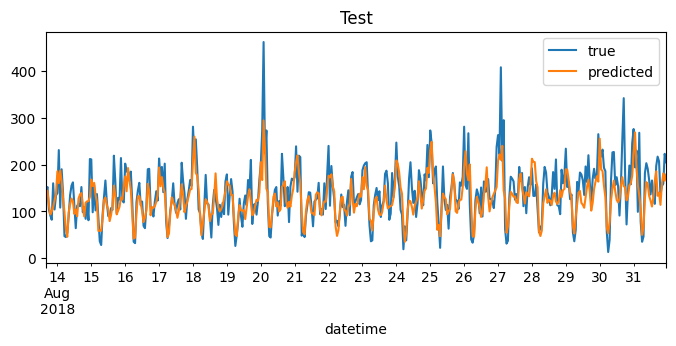

In [22]:
pred = pd.Series(pred, index=y_test.index)

plt.figure(figsize=(8, 3))
y_test.plot(label='true', title='Test')
pred.plot(label='predicted')
plt.legend()
plt.show()

## Вывод

Целью проекта было создание модели для предсказания количества заказов такси на следующий час. В нашем распоряжении были историчекие данные за полгода о заказах такси в аэропортах. Для анализа и обучения модели мы ресемплировали данные по одному часу.

В ходе анализа данных был обнаружен тренд на увеличение числа заказов такси с марта по август 2018 г, а также были найдены две сезонные компоненты: недельная - больше всего заказов такси в начале и конце рабочей недели; суточная - пики заказов в 10, 16 и 00 часов и минимум в 6 утра.

Для обучения моделей были созданы признаки: календарные признаки (месяц, день, день недели, час), отстающие (lag) значения - 24 шт, скользящее среднее по 4 точкам.

Мы рассмотрели четыре модели: линейную регрессию, случайный лес, LightGBM и CatBoost. Среди этих моделей по метрике RMSE лучшей оказалась **CatBoostRegressor** с параметрами: 'depth' = 5, 'iterations' = 250, 'learning_rate' = 0.1. На тестовой выборке лучшая модель показала RMSE = 39.8, что лучше требуемой RMSE = 48.